In [1]:
# Get the data for expeirment
import pandas as pd 
import numpy as np
import time
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF
import seaborn as sns
import TsModel
import GprModel
import TsModel_constant
import torch
from sklearn.metrics import r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
from keras import layers, models

device = torch.device("cuda:0")
print(f"Keras version is {keras.__version__}")
print(f"Num GPUs Available: {torch.cuda.device_count()}")
plt.rcParams.update({'font.size': 20})

Keras version is 3.1.1
Num GPUs Available: 1


In [33]:
exp26_results = {
    'nn_train_accuracy' : nn_train_accuracy,
    'nn_test_accuracy':nn_test_accuracy,
    'nn_r2s':nn_r2s,
    'nn_time':nn_time,
    'gp_train_accuracy':gp_train_accuracy,
    'gp_test_accuracy':gp_test_accuracy,
    'gp_r2s':gp_r2s,
    'gp_time':gp_time,
    'tsl_train_accuracy' : tsl_train_accuracy,
    'tsl_test_accuracy' :tsl_test_accuracy,
    'tsl_r2s':tsl_r2s,
    'tsl_time': tsl_time,
    'tsc_train_accuracy':tsc_train_accuracy,
    'tsc_test_accuracy':tsc_test_accuracy,
    'tsc_r2s':tsc_r2s,
    'tsc_time':tsc_time
}

In [34]:
#%store exp26_results 

Stored 'exp26_results' (dict)


In [5]:
# Train and test the solar data set
x_train = pd.read_csv('Data/FES/solar2_x_train.csv')
x_test = pd.read_csv('Data/FES/solar2_x_test.csv')
y_train = pd.read_csv('Data/FES/solar2_y_train.csv')
y_test = pd.read_csv('Data/FES/solar2_y_test.csv')

In [6]:
number_of_folds = 10

# Source: From the TSmodel
def preprocess_data(train_x, test_x, train_y, test_y):
    feature_scaler = StandardScaler()
    scaled_train_x = feature_scaler.fit_transform(train_x)
    scaled_test_x = feature_scaler.transform(test_x)

    # target_scaler = StandardScaler()  
    # scaled_train_y = target_scaler.fit_transform(train_y)
    # scaled_test_y = target_scaler.transform(test_y)    
    # return scaled_train_x, scaled_test_x, scaled_train_y, scaled_test_y, feature_scaler, target_scaler    

    return scaled_train_x, scaled_test_x, feature_scaler    

def build_neural_network_model():
    model = models.Sequential()
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(10, activation=keras.activations.tanh))    
    model.add(layers.Dense(1, activation=keras.activations.relu))
    return model

In [7]:
x_train, x_test, feature_scaler = preprocess_data(x_train, x_test, y_train, y_test)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [20]:
nn_train_accuracy = []
nn_test_accuracy = []
nn_r2s = []
nn_time = []
histories = []

def do_nn_exp():
    for fold in range(number_of_folds):
        neural_network_model = build_neural_network_model()

        neural_network_model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=0.1),
            loss=keras.losses.MeanSquaredError(),
            metrics=[keras.metrics.RootMeanSquaredError()]
        )

        start_time = time.time()
        history = neural_network_model.fit(
            x_train, 
            y_train,
            epochs=200, 
            shuffle=True
        )
        time_used = time.time() - start_time

        _, train_rmse = neural_network_model.evaluate(x_train, y_train)
        nn_train_accuracy.append(train_rmse)
        _, test_rmse = neural_network_model.evaluate(x_test, y_test)
        nn_test_accuracy.append(test_rmse)
        nn_r2 = r2_score(y_test, neural_network_model.predict(x_test))
        nn_r2s.append(nn_r2)
        nn_time.append(time_used)
        histories.append(history)
    
    return neural_network_model

In [21]:
nn_model = do_nn_exp()

Epoch 1/200


72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 15989104.0000 - root_mean_squared_error: 3916.2117
Epoch 2/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 25988508.0000 - root_mean_squared_error: 5024.7412
Epoch 3/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 24538698.0000 - root_mean_squared_error: 4894.5103
Epoch 4/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 30434572.0000 - root_mean_squared_error: 5354.5479
Epoch 5/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 22365488.0000 - root_mean_squared_error: 4703.5518
Epoch 6/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 18547802.0000 - root_mean_squared_error: 4280.9453
Epoch 7/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19036424.0000 - root_mean_squared_error: 4288.0396
Epoch 8/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 14359001.0000 - root_mean_squared_error: 3753.4258
Epoch 9/200
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 16341676.0000 - root_mean_squared_error: 3986.7151
Epoch 10/200
72/72 ━━━

In [22]:
nn_train_accuracy_mean = np.round(np.mean(nn_train_accuracy), 3)
nn_train_accuracy_std = np.round(np.std(nn_train_accuracy), 3)
nn_test_accuracy_mean = np.round(np.mean(nn_test_accuracy), 3)
nn_test_accuracy_std = np.round(np.std(nn_test_accuracy),3)
nn_r2_mean = np.round(np.mean(nn_r2s),3)
nn_r2_std = np.round(np.std(nn_r2s),3)
nn_time_mean = np.round(np.mean(nn_time),3)
nn_time_std = np.round(np.std(nn_time),3)

print(f"NN Train RMSE: {nn_train_accuracy_mean} ± {nn_train_accuracy_std}")
print(f"NN Test RMSE: {nn_test_accuracy_mean} ± {nn_test_accuracy_std}")
print(f"NN R2: {nn_r2_mean} ± {nn_r2_std}")
print(f"NN Time: {nn_time_mean} ± {nn_time_std}")

NN Train RMSE: 3811.551 ± 24.9
NN Test RMSE: 4027.769 ± 21.481
NN R2: 0.169 ± 0.009
NN Time: 60.052 ± 3.164


 1/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 1.0, 'NN prediction vs true value for testing data')

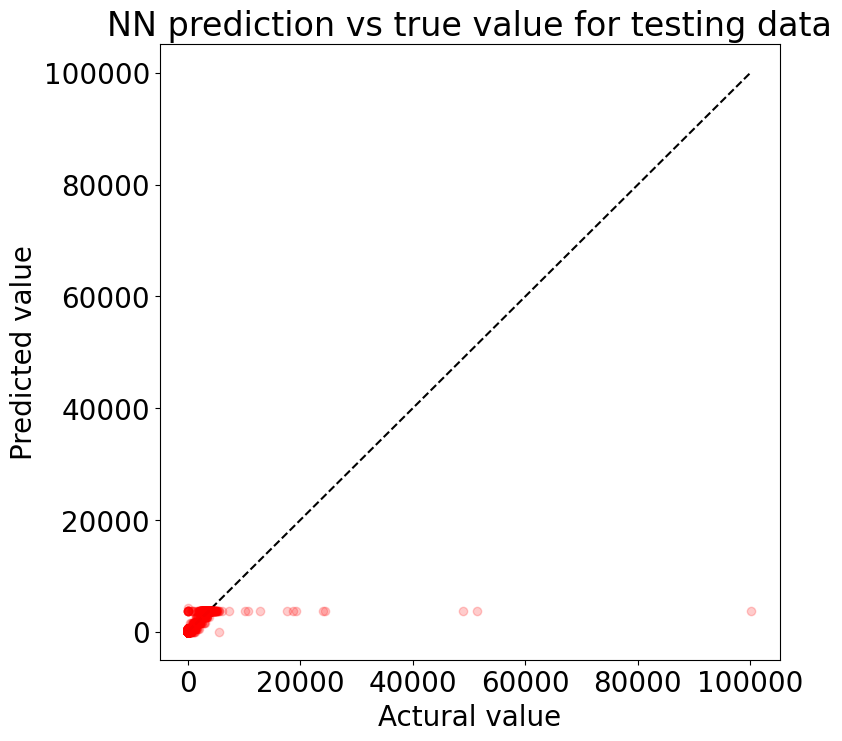

In [23]:
# Visualiza the error

plt.figure(figsize=(8,8))    
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, nn_model.predict(x_test), 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('NN prediction vs true value for testing data')

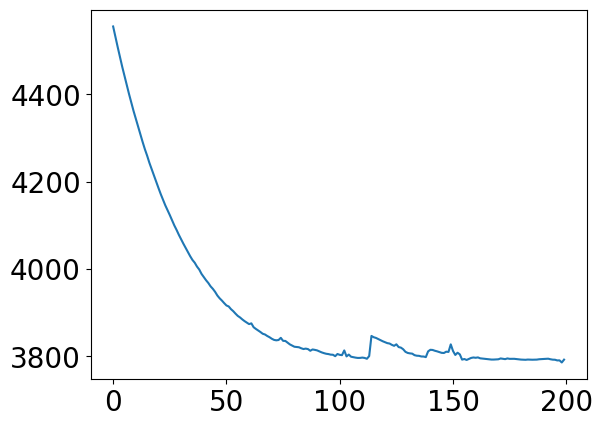

In [24]:
plt.plot(histories[0].history['root_mean_squared_error'], label='Training RMSE')

In [21]:
#nn_model.save('small_wind_turbine_nn.keras')

In [25]:
# GPR model
gp_train_accuracy = []
gp_test_accuracy = []
gp_r2s = []
gp_time = []
gpr_model = None

for fold in range(number_of_folds):
    
    kernel = 1.0 * Matern(length_scale=1.0, nu=1.5)
    gpr_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y=False)
    indices = np.random.choice(x_train.shape[0], 2000, replace=False)            

    start_time = time.time()
    gpr_model.fit(x_train[indices,:], y_train[indices,:])
    time_used = time.time() - start_time

    train_means = gpr_model.predict(x_train)
    test_means = gpr_model.predict(x_test)

    train_rmse = root_mean_squared_error(y_train, train_means)
    test_rmse = root_mean_squared_error(y_test, test_means)

    gp_train_accuracy.append(train_rmse)
    gp_test_accuracy.append(test_rmse)
    gp_r2 = r2_score(y_test, test_means)
    gp_r2s.append(gp_r2)
    gp_time.append(time_used)


e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-packages\sklearn\gaussian_process\kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
e:\Users\PPL\anaconda3\envs\pytorch\Lib\site-

In [26]:
gp_train_accuracy_mean = np.round(np.mean(gp_train_accuracy), 3)
gp_train_accuracy_std = np.round(np.std(gp_train_accuracy), 3)
gp_test_accuracy_mean = np.round(np.mean(gp_test_accuracy), 3)
gp_test_accuracy_std = np.round(np.std(gp_test_accuracy),3)
gp_r2_mean = np.round(np.mean(gp_r2s),3)
gp_r2_std = np.round(np.std(gp_r2s),3)
gp_time_mean = np.round(np.mean(gp_time),3)
gp_time_std = np.round(np.std(gp_time),3)

print(f"GP Train RMSE: {gp_train_accuracy_mean} ± {gp_train_accuracy_std}")
print(f"GP Test RMSE: {gp_test_accuracy_mean} ± {gp_test_accuracy_std}")
print(f"GP R2: {gp_r2_mean} ± {gp_r2_std}")
print(f"GP Time: {gp_time_mean} ± {gp_time_std}")

GP Train RMSE: 1368.038 ± 437.874
GP Test RMSE: 4637.532 ± 105.706
GP R2: -0.102 ± 0.049
GP Time: 20.191 ± 16.275


In [27]:
# TS model
# Linear conclusion

def ts_relu_wrapper(pred):
    return np.maximum(0, pred)

# TS with linear conclusion
tsl_train_accuracy = []
tsl_test_accuracy = []
tsl_r2s = []
tsl_time = []
tsl_model = None

for fold in range(number_of_folds):
    ts_model = TsModel.TsModel(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsl_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsl_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsl_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsl_test_pred)

    tsl_train_accuracy.append(train_rmse)
    tsl_test_accuracy.append(test_rmse)
    tsl_r2 = r2_score(y_test, tsl_test_pred)
    tsl_r2s.append(tsl_r2)
    tsl_time.append(time_used)
    tsl_model = ts_model


FCM training RMSE: 3650.7921447287035
FCM training RMSE: 3644.2119528826497
FCM training RMSE: 3659.2519770664862
FCM training RMSE: 3679.2712241706104
FCM training RMSE: 3685.365730354082
FCM training RMSE: 3633.8052305213523
FCM training RMSE: 3637.7971927191224
FCM training RMSE: 3655.194902385151
FCM training RMSE: 3662.4100264562444
FCM training RMSE: 3662.4663334103225


In [28]:
tsl_train_accuracy_mean = np.round(np.mean(tsl_train_accuracy), 3)
tsl_train_accuracy_std = np.round(np.std(tsl_train_accuracy), 3)
tsl_test_accuracy_mean = np.round(np.mean(tsl_test_accuracy), 3)
tsl_test_accuracy_std = np.round(np.std(tsl_test_accuracy),3)
tsl_r2_mean = np.round(np.mean(tsl_r2s),3)
tsl_r2_std = np.round(np.std(tsl_r2s),3)
tsl_time_mean = np.round(np.mean(tsl_time),3)
tsl_time_std = np.round(np.std(tsl_time),3)

print(f"TS Linear Train RMSE: {tsl_train_accuracy_mean} ± {tsl_train_accuracy_std}")
print(f"TS Linear Test RMSE: {tsl_test_accuracy_mean} ± {tsl_test_accuracy_std}")
print(f"TS Linear R2: {tsl_r2_mean} ± {tsl_r2_std}")
print(f"TS Linear Time: {tsl_time_mean} ± {tsl_time_std}")

TS Linear Train RMSE: 3655.016 ± 16.88
TS Linear Test RMSE: 3999.872 ± 58.73
TS Linear R2: 0.18 ± 0.024
TS Linear Time: 0.546 ± 0.131


Text(0.5, 1.0, 'TS prediction vs true value for testing data')

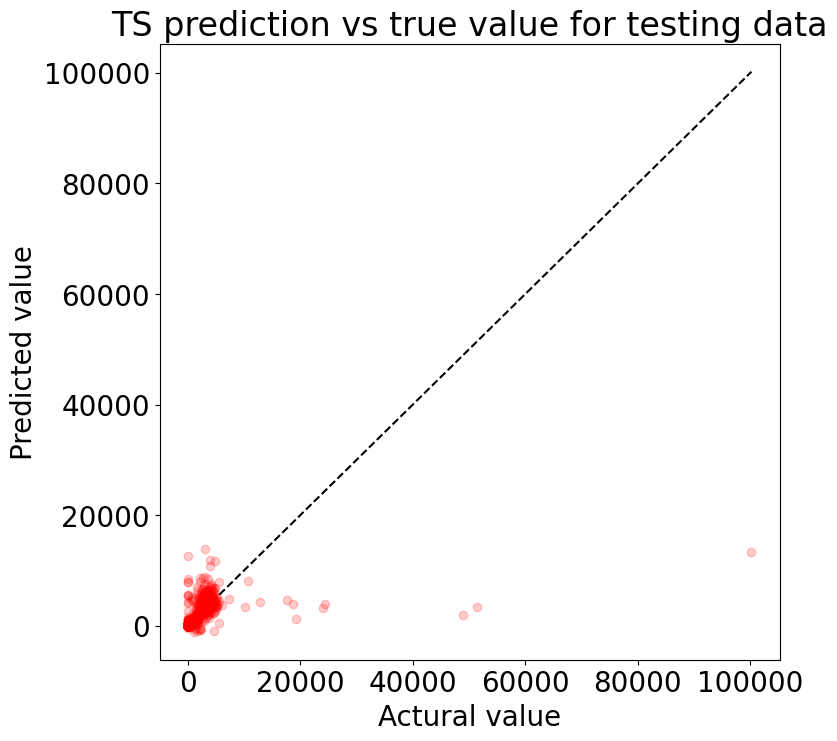

In [29]:
# Visualiza the error
ts_pred = tsl_model.predict(x_test)

plt.figure(figsize=(8,8))    
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, ts_pred, 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('TS prediction vs true value for testing data')

In [30]:
# TS model
# Constant conclusion
tsc_train_accuracy = []
tsc_test_accuracy = []
tsc_r2s = []
tsc_time = []
tsc_model = None

for fold in range(number_of_folds):
    ts_model = TsModel_constant.TsModel_constant(number_of_rules=25, fuzzification_coefficient=1.2)
    
    start_time = time.time()
    ts_model.fit(x_train, y_train)
    time_used = time.time() - start_time

    tsc_train_pred = ts_relu_wrapper(ts_model.predict(x_train))
    tsc_test_pred = ts_relu_wrapper(ts_model.predict(x_test))

    train_rmse = root_mean_squared_error(y_train, tsc_train_pred)
    test_rmse = root_mean_squared_error(y_test, tsc_test_pred)

    tsc_train_accuracy.append(train_rmse)
    tsc_test_accuracy.append(test_rmse)
    tsc_r2 = r2_score(y_test, tsc_test_pred)
    tsc_r2s.append(tsc_r2)
    tsc_time.append(time_used)
    tsc_model = ts_model

(2281, 150)
[[3.73969950e-06 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [7.58906319e-12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.09884739e-05 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 ...
 [9.31818136e-12 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.94873580e-11 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [9.09829197e-13 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]
(2281, 25)
[[3.73969950e-06 8.64475916e-10 1.63878301e-09 ... 3.65763325e-07
  2.72946411e-07 2.10936996e-03]
 [7.58906319e-12 9.99946203e-01 5.31543051e-05 ... 4.90054974e-09
  2.06975880e-10 2.95398497e-12]
 [2.09884739e-05 2.09731420e-07 5.89564557e-07 ... 1.28720160e-04
  3.49032975e-03 2.63503234e-04]
 ...
 [9.31818136e-12 1.24662472e-08 7.12474153e-09 ... 2.94953261e-09
  3.12758

In [31]:
tsc_train_accuracy_mean = np.round(np.mean(tsc_train_accuracy), 3)
tsc_train_accuracy_std = np.round(np.std(tsc_train_accuracy), 3)
tsc_test_accuracy_mean = np.round(np.mean(tsc_test_accuracy), 3)
tsc_test_accuracy_std = np.round(np.std(tsc_test_accuracy),3)
tsc_r2_mean = np.round(np.mean(tsc_r2s),3)
tsc_r2_std = np.round(np.std(tsc_r2s),3)
tsc_time_mean = np.round(np.mean(tsc_time),3)
tsc_time_std = np.round(np.std(tsc_time),3)

print(f"TS Constant Train RMSE: {tsc_train_accuracy_mean} ± {tsc_train_accuracy_std}")
print(f"TS Constant Test RMSE: {tsc_test_accuracy_mean} ± {tsc_test_accuracy_std}")
print(f"TS Constant R2: {tsc_r2_mean} ± {tsc_r2_std}")
print(f"TS Constant Time: {tsc_time_mean} ± {tsc_time_std}")

TS Constant Train RMSE: 3802.818 ± 3.094
TS Constant Test RMSE: 4036.999 ± 7.352
TS Constant R2: 0.165 ± 0.003
TS Constant Time: 0.449 ± 0.119


Text(0.5, 1.0, 'TS prediction vs true value for testing data')

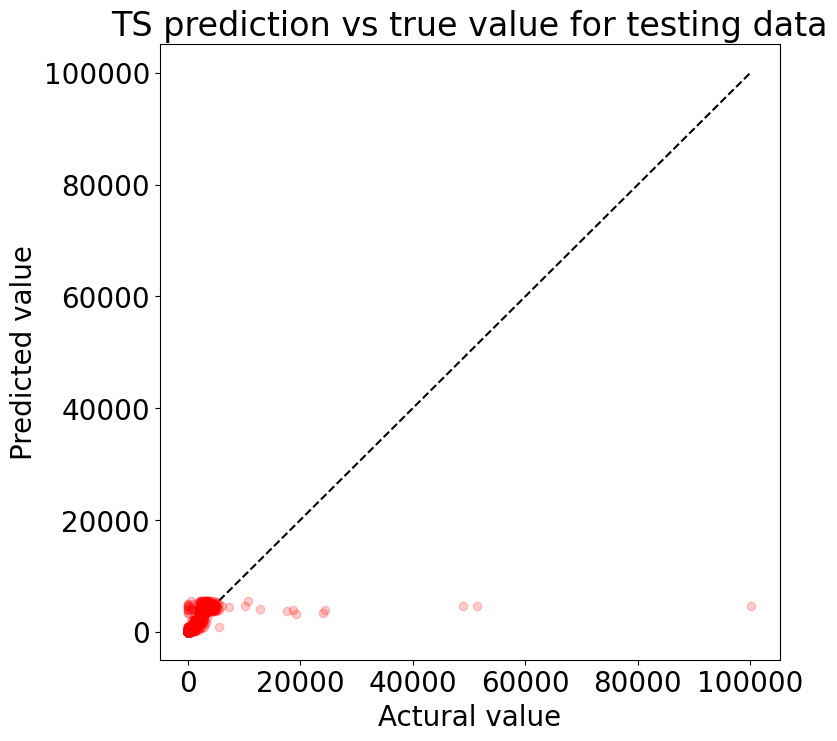

In [32]:
# Visualiza the error
ts_const_pred = ts_relu_wrapper(tsc_model.predict(x_test))

plt.figure(figsize=(8,8))    
plt.plot([min(y_test),max(y_test)], [min(y_test),max(y_test)], 'k--')
plt.plot(y_test, ts_const_pred, 'ro', alpha=.2)
plt.xlabel('Actural value')
plt.ylabel('Predicted value')
plt.title('TS prediction vs true value for testing data')